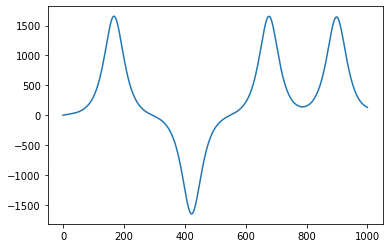

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dynamicalsystems.lorenz63 import Lorenz63Model
from DAmethod.ETKF import ETKF
%matplotlib inline

In [2]:
Nensemble = 64 // 2
period_assim = 1
Nsteps = 200
state_dimension= 3
inflation_factor = 1.01

In [3]:
# Properties of the model
dt = 0.02
Lorenz63Model.dt = dt
H = np.atleast_2d([[1, 0, 0], [0, 1, 0]])
sigobs = 5
R = sigobs * np.atleast_2d([[1, 0], [0, 1]])

In [4]:
truth = Lorenz63Model()
burn = 5000
truth.set_initial_state(-burn * dt, np.array([0, 1, 0]))
truth.forward(burn)  # Burn-in period
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(1) * sigobs
    return truth.t[-1], y
initial_state = truth.state_vector[:, -1]

In [5]:
etkf = ETKF(state_dimension, Nensemble, R, inflation_factor)
etkf.H = H
etkf.R = R
etkf.set_forwardmodel(lambda x: Lorenz63Model.integrate(0, x, period_assim)[1][:, -1])
etkf.generate_ensemble(mean=initial_state, cov=np.eye(state_dimension))


dETKF = etkf.run(Nsteps, get_obs=generate_observations)

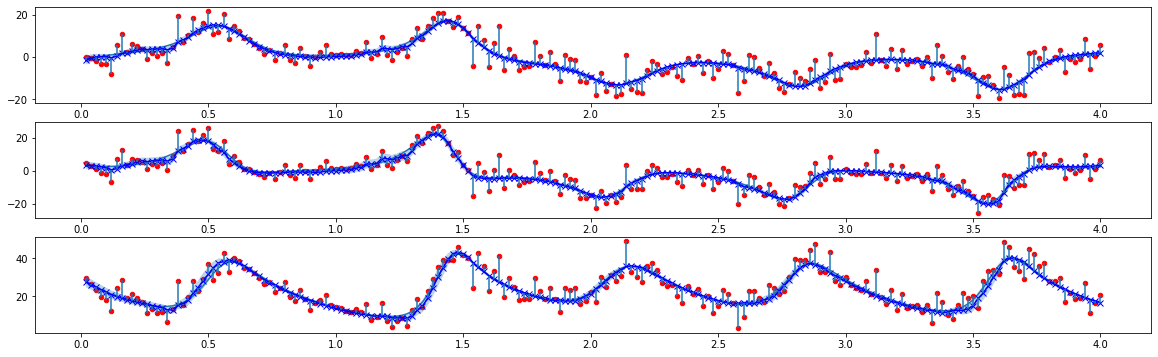

In [6]:
xabar = np.array(dETKF["ensemble_a"]).mean(-1)
xa_std = np.array(dETKF["ensemble_a"]).std(-1)
xbarpstd = xabar + 3 * xa_std
xbarmstd = xabar - 3 * xa_std
obs = np.array(dETKF["observations"])
plt.figure(figsize=(20, 6))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(truth.t[(burn + 1):], truth.state_vector[i, (burn + 1):])
    plt.scatter(dETKF["time"], obs[:, i], marker="o", c="red", s=20)
    plt.plot(dETKF["time"], xabar[:, i], "x-", color="blue")
    plt.vlines(dETKF["time"], xabar[:, i], obs[:, i])
    plt.fill_between(dETKF["time"], xbarmstd[:, i], xbarpstd[:, i], alpha=0.3)
plt.show()

     Analysis error:  0.35225056816950484
  Observation error:   24.843540465003738


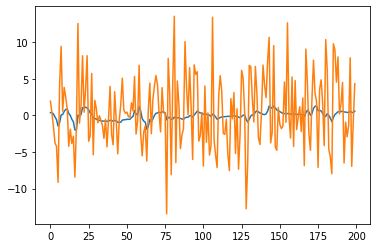

In [7]:
analysis_error = xabar[:, 0] - truth.state_vector[0, burn + period_assim::period_assim]
observation_error = obs[:, 0] - truth.state_vector[0, burn + period_assim::period_assim]
ea = (analysis_error**2).mean()
eo = (observation_error**2).mean()
plt.plot(analysis_error)
plt.plot(observation_error)
print(f"{'Analysis error:': >20} {ea:>20}")
print(f"{'Observation error:': >20} {eo:>20}")